##**Week 3(Training on Imdb Data)**

In [6]:
import tensorflow_datasets as tfds


# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the subwords tokenizer
tokenizer = info.features['text'].encoder

BUFFER_SIZE = 10000
BATCH_SIZE = 128

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

In [7]:
# test what lstm does

import tensorflow as tf
import numpy as np


# Hyperparams
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8


print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values(used as our embedding vect here)
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


In [8]:
# test what conv1D does
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 20
filters = 128
kernel_size = 5

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'filters: {filters}')
print(f'kernel_size: {kernel_size}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Pass array to convolution layer and inspect output shape
conv1d = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')

# Pass array to max pooling layer and inspect output shape
gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)
shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


In [9]:
# viz results
import matplotlib.pyplot as plt

# helper to plot graph
def plot_graphs(history, metric):
  epoch = len(history.history[metric])
  plt.plot(range(epoch), history.history[metric])
  plt.plot(range(epoch), history.history[f"val_{metric}"])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, f"val_{metric}"])
  plt.show()


**Testing with lstm, gru, conv1D and Flatten() after Embedding Layer**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 28)          229180    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 56)         12768     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 56)               19040     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 342       
                                                                 
 batch_normalization_1 (Batc  (None, 6)                24        
 hNormalization)                                                 
                                                      

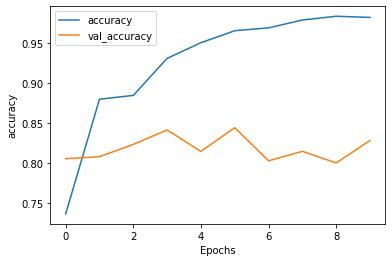

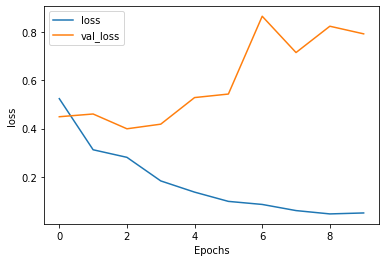

In [11]:
 # since using subwords variation of imdb which is token, no need to tokenzie sentence words and pad since already done above

# lstm model(no wonder lstm nets aren't as deep as cnn or fcnn, they are quite slow to train)
embedding_dim = 28
lstm1_dim = 28
lstm2_dim = 28
dense_dim = 6

model= tf.keras.models.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print(f"{model.summary()}\n")

NUM_EPOCHS = 10

history = model.fit(train_dataset, epochs = NUM_EPOCHS, validation_data = test_dataset)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 28)          229180    
                                                                 
 global_average_pooling1d_2   (None, 28)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 6)                 174       
                                                                 
 batch_normalization_4 (Batc  (None, 6)                24        
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 1)                 7         
                                                                 
Total params: 229,385
Trainable params: 229,373
Non-tr

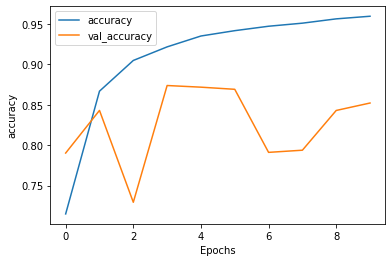

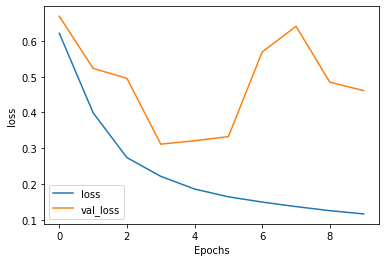

In [18]:
# Flatten
embedding_dim = 28
dense_dim = 6


# Model Definition with a Flatten layer
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print(f"{model.summary()}\n")

NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs = NUM_EPOCHS, validation_data = test_dataset)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 16)          130960    
                                                                 
 bidirectional_8 (Bidirectio  (None, 56)               7728      
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 6)                 342       
                                                                 
 batch_normalization_8 (Batc  (None, 6)                24        
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 1)                 7         
                                                                 
Total params: 139,061
Trainable params: 139,049
Non-t

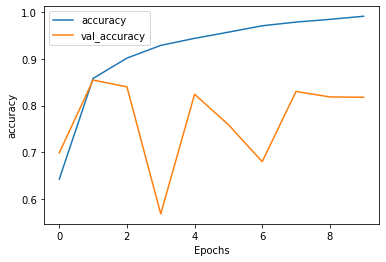

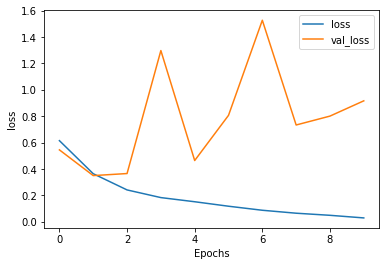

In [24]:
# GRU(Gated Recurrent Unit)
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 28
dense_dim = 6

# Model Definition with GRU(faster than lstm)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print(f"{model.summary()}\n")

NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs = NUM_EPOCHS, validation_data = test_dataset)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 16)          130960    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         10368     
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_21 (Dense)            (None, 6)                 774       
                                                                 
 batch_normalization_7 (Batc  (None, 6)                24        
 hNormalization)                                                 
                                                                 
 dense_22 (Dense)            (None, 1)               

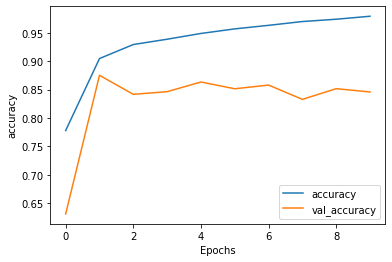

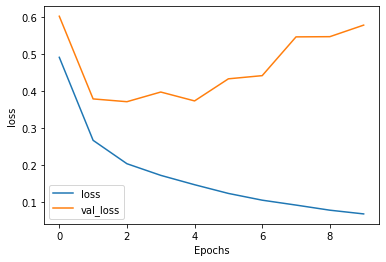

In [23]:
# Convolutions

# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print(f"{model.summary()}\n")

NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs = NUM_EPOCHS, validation_data = test_dataset)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [23]:
# N.B: we could use transfer learning for our word emnbeddings too, will help make things better
# Work on the Sacasm dataaset later but with pretrained embeddings

In [20]:
# !nvidia-smi

Thu Sep 15 03:10:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   5096MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##**Week 4(Text Generation)**##
* Note: If this is a big corpus of texts, character based will be a better option since num of unique char is less than num of unique words

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt

--2022-09-15 21:16:09--  https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘irish-lyrics-eof.txt’

irish-lyrics-eof.tx 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2022-09-15 21:16:09 (91.6 MB/s) - ‘irish-lyrics-eof.txt’ saved [68970/68970]



In [3]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result(corpus is a list of phrases of type string)
print(corpus)

['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay', 'then came a lusty sailor', 'who chanced to pass my way', 'and stole my bunch of thyme away', 'the sailor gave to me a rose', 'a rose that never would decay', 'he gave it to me to keep me reminded', 'of when he stole my thyme away', 'sleep, my child, and peace attend thee', 'all through the night', 'guardian angels god will send thee', 'soft the drowsy hours are creeping', 'hill and dale in slumber sleeping', 'i my loving vigil keeping', 'while the moon her watch is keeping', 'while the weary world is sleeping', 'oer thy spirit gently stealing', 'visions of delight revealing', 'breathes a pure 

In [4]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)

# Define the total words. we add 1 for index "0" since it's just a padded token
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'thro

In [5]:
# Preprocess the dataset

input_sequences = []


# iter over every line in corpus
for line in corpus:

  # tokenize line in focus(since result is 2d array index [0] to get token list)
  token_list = tokenizer.texts_to_sequences([line])[0]

  # Loop over the line and gen subphrases
  # e.g [4, 5] when i = 1
  # e.g [4, 5, 9] when i = 2
  for i in range(1, len(token_list)):

    # generate subprhase
    n_gram_sequence = token_list[:i+ 1]

    # Appends subprhase to the sequence list
    input_sequences.append(n_gram_sequence)


# gets the length of the longest line or sequence
max_sequence_len = max([len(x) for x in input_sequences])

# pads. use pre since our label will be taken from last token in each sequence
input_sequences = np.array(pad_sequences(input_sequences, maxlen= max_sequence_len, padding = "pre"))

xs, labels = input_sequences[:,:-1], input_sequences[:, -1]

# one hot encode y
ys = tf.keras.utils.to_categorical(labels, num_classes = total_words)

In [6]:
# to check if implementation is correct

sentence = corpus[0].split() # list of words
print(f'sample sentence: {sentence}')

# init token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  token_list.append(tokenizer.word_index[word])

print(token_list)


# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[51, 12, 96, 1217, 48, 2, 69]
token list: [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
decoded to text: ['come all ye maidens young and']
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 69


In [10]:
# viz results
import matplotlib.pyplot as plt

# helper to plot graph
def plot_graphs(history, metric):
  epoch = len(history.history[metric])
  plt.plot(range(epoch), history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()

In [14]:
# Build Model

# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.001

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 100)           269000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 300)              301200    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2690)              809690    
                                                                 
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


Epoch 1/300
377/377 [==============================] - 6s 8ms/step - loss: 6.7634 - accuracy: 0.0645
Epoch 2/300
377/377 [==============================] - 3s 8ms/step - loss: 6.2265 - accuracy: 0.0758
Epoch 3/300
377/377 [==============================] - 3s 8ms/step - loss: 5.9600 - accuracy: 0.0861
Epoch 4/300
377/377 [==============================] - 3s 8ms/step - loss: 5.6623 - accuracy: 0.0979
Epoch 5/300
377/377 [==============================] - 3s 8ms/step - loss: 5.3235 - accuracy: 0.1159
Epoch 6/300
377/377 [==============================] - 3s 8ms/step - loss: 4.9699 - accuracy: 0.1347
Epoch 7/300
377/377 [==============================] - 3s 8ms/step - loss: 4.6179 - accuracy: 0.1576
Epoch 8/300
377/377 [==============================] - 3s 8ms/step - loss: 4.2645 - accuracy: 0.1872
Epoch 9/300
377/377 [==============================] - 3s 8ms/step - loss: 3.9192 - accuracy: 0.2248
Epoch 10/300
377/377 [==============================] - 3s 8ms/step - loss: 3.5776 - accura

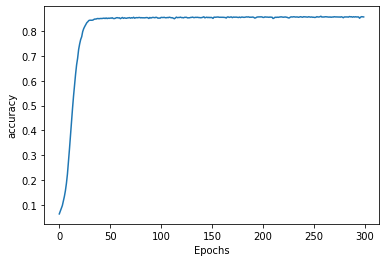

In [15]:
epochs = 500

history = model.fit(xs, ys, epochs = epochs)

plot_graphs(history, "accuracy")

In [19]:
# Define seed text to use to gen next word
seed_text = "help me out mate, come on"

# define num of words to predict or gen for next sequence
next_words = 100

for _ in range(next_words):

  # at each iter gen a new word append to seed_text and feed back again until next_words - 1 is reached
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

  # pad sequence, and remove 1 since we are padding x which is deficit of the label word
  token_list = pad_sequences([token_list], maxlen= max_sequence_len - 1, padding = "pre")

  probabilities = model.predict(token_list)

  # might cause repition of predicted words
  # predicted = np.argmax(probabilities, axis = -1)[0]

  # sorts probab by ascending order and pick one of the top 3, causes less repition of prediction
  choice = np.random.choice([1, 2, 3])  # picks random num from 1, 2, 3
  predicted = np.argsort(probabilities)[0][-choice]

  # Ignore if index is 0 since that is padding
  if(predicted != 0):

    # get word associated with that index
    output_word = tokenizer.index_word[predicted]

    # combine predicted word at this time time with seed_text to feed in again
    seed_text += " " + output_word


# print the result
print(seed_text)

help me out mate, come on me go with my molly malone on me by a hair fairy judge were a banbridge ould talk fairy watch maiden catch birds swore fathers mullingar ceannt view struck bottle ringum years siren fell napper life thou happy ground to keep your fathers owen owen cheeks loving caught coaxing john fairy li custom twenty owen banbridge consent high twenty owen caught green raking twas hardly bad coaxing rungum twenty dreaming beg fathers stony john dreaming began ground ground by gets laughs ground ringum bundle there down by arose rig paddys erins owen hillways wheeled not round ground trace down with


(0, 0)

**Character based RNN for Shakepare dataset text generation**

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

# downloads the dataset
path_to_file = tf.keras.utils.get_file("shakespeare.txt", 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


In [2]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters\n')

# print first n characters in text
print(text[:103])

Length of text: 1115394 characters

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You ar


In [3]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [4]:
print(vocab)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
# vect the chars to tokens or numeric ID
example_texts = ["abcdefg", "xyz"]

# splits each array element into list of chars
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
print(chars)

# layers to get ids from char
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary = list(vocab), mask_token = None
)

ids = ids_from_chars(chars)
print(ids)


# gets char back from the char ids
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary = ids_from_chars.get_vocabulary(), invert = True, mask_token = None
)

chars = chars_from_ids(ids)
print(chars)

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>
<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>
<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>


In [6]:
# helper to combine chars into text to form a meaning
def texts_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis = -1)

texts_from_ids(ids)

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'abcdefg', b'xyz'], dtype=object)>

In [7]:
# create train examples and labels
# each example input_sequence as same seq_length with label seq_length only that label is shift one char to right
# e.g example is Hell and label is ello

all_ids = ids_from_chars(tf.strings.unicode_split(text, "UTF-8"))
print(all_ids)


# convert char ids into stream of char inidices, by creating tf dataset
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

tf.Tensor([19 48 57 ... 46  9  1], shape=(1115394,), dtype=int64)
F
i
r
s
t
 
C
i
t
i


In [8]:
seq_length = 100

# gets batch of sequence of desired length, and drop batch that doesn't meet up with this length
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(3):

  # prints the chars
  # print(chars_from_ids(seq))

  # prints the combined chars as text
  print(texts_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"


In [9]:
# helper to do splitting into examples and labels
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:] # shift one char to right of input_text
  return input_text, target_text

# test with this
split_input_target(list("Tensorflow"))  

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [10]:
# gets our dataset of input_seq and target_seq
dataset = sequences.map(split_input_target)


# a check to see 
for input, target in dataset.take(1):
  print("Input :", texts_from_ids(input).numpy())
  print("Target:", texts_from_ids(target).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [11]:
# Shuffle Dataset and batch it, while also setting prefetching strtegies

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

* Build the model

In [47]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


# easier to use this than keras Sequential API which we need us to manage state in text generation
class MyModel(tf.keras.Model):
  
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru= tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state = True)
    # self.gru2 = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state = True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  # called in model.fit()
  def call(self, inputs, states = None, return_state = False, training = False):
    x = inputs # character in focus
    x = self.embedding(x, training = training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state = states, training = training)
    # x, states = self.gru2(x, initial_state = states, training = training)
    x = self.dense(x, training = training)

    if return_state:
      return x, states
    else:
      return x


model = MyModel(
    vocab_size, embedding_dim, rnn_units
)

In [48]:
# test model to see if behaving well
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    # vocab size is 66 which was previously 65 but on addition of UNK makes it 66
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)") 

model.summary()

(64, 100, 66) # (batch_size, sequence_length, vocab_size)
Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  16896     
                                                                 
 gru_5 (GRU)                 multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [49]:
# to get actual pred, we sample from output distro, to get char indices. Also helps having repeated pred
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples = 1)  # from predictions random select one choice
sampled_indices = tf.squeeze(sampled_indices, axis = -1).numpy() # removes last dim

print(sampled_indices)

print("Input:\n", texts_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", texts_from_ids(sampled_indices).numpy())

[65 56  1  5 65 38 39 63 14 62 44 21 50 25 60 18 37 47 37 39 54 35 29 34
 36 29 27 32  2 11 57 44 46 33 64 61 57 38 55 27 58 38 19 21 63 63 20 45
 41 35 27 36 11 52 39 46 45 29 29 32 14 16 15  0 57 11 44 36 24 47 35 50
 60 28 13  9 31 52 12 10 27 26 26  5 37 34 29 34  8 51 13 21 62 26 33 44
 62  5 52 55]
Input:
 b'm,\nMore than thou hast, and with it joy thy life;\nSo as thou livest in peace, die free from strife:\n'

Next Char Predictions:
 b'zq\n&zYZxAweHkLuEXhXZoVPUWPNS :regTyvrYpNsYFHxxGfbVNW:mZgfPPSACB[UNK]r:eWKhVkuO?.Rm;3NMM&XUPU-l?HwMTew&mp'


* Train Model

In [50]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True)

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Mean loss:        ", example_batch_mean_loss)

# if this is higher than vocab which is 66,then model is very sure of her answers
print(tf.exp(example_batch_mean_loss).numpy())

Mean loss:         tf.Tensor(4.19116, shape=(), dtype=float32)
66.099434


In [51]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = loss, metrics = ["accuracy"])

In [52]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor = "accuracy",
    save_best_only = True,
    save_weights_only=True)

In [53]:
EPOCHS = 30

history = model.fit(dataset, epochs = EPOCHS, callbacks = checkpoint_callback, use_multiprocessing=True)

Epoch 1/30
172/172 [==============================] - 13s 56ms/step - loss: 2.7447 - accuracy: 0.2759
Epoch 2/30
172/172 [==============================] - 11s 59ms/step - loss: 1.9992 - accuracy: 0.4147
Epoch 3/30
172/172 [==============================] - 12s 57ms/step - loss: 1.7202 - accuracy: 0.4899
Epoch 4/30
172/172 [==============================] - 11s 57ms/step - loss: 1.5575 - accuracy: 0.5330
Epoch 5/30
172/172 [==============================] - 11s 56ms/step - loss: 1.4559 - accuracy: 0.5589
Epoch 6/30
172/172 [==============================] - 11s 56ms/step - loss: 1.3858 - accuracy: 0.5767
Epoch 7/30
172/172 [==============================] - 11s 56ms/step - loss: 1.3337 - accuracy: 0.5897
Epoch 8/30
172/172 [==============================] - 11s 57ms/step - loss: 1.2881 - accuracy: 0.6011
Epoch 9/30
172/172 [==============================] - 12s 56ms/step - loss: 1.2471 - accuracy: 0.6118
Epoch 10/30
172/172 [==============================] - 11s 57ms/step - loss: 1.207

* To generate text, we use a loop. passing in previously generated text and previous_state to model again for work

In [85]:
# Defines the one step char generation, that will be iterated to get sentence
# for better text gen play around by adding more gru to MyModel and adjust temoerature param
class OneStep(tf.keras.Model):

  def __init__(self, model, chars_from_ids, ids_from_chars, temperature = 1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # create mask to prevent [UNK] from being generated
    skip_ids = self.ids_from_chars(["[UNK]"])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index i.e [UNK] Index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  
  # tf function to speed up wok
  @tf.function
  def generate_one_step(self, inputs, states):
    # Convert strings to char token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    
    # Only use the last prediction, which will return [batch, next_char_logits or vocab logits]
    predicted_logits = predicted_logits[:, -1, :]
    # print(predicted_logits) # prints just once since it's py side effect
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [96]:
import time

one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature = 1.5)

next_char = tf.constant(["ROMEO:"])

result = [next_char]
states = None

start = time.time()

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode("utf-8"),
      "\n\n" + "_"*80) # just for formatting the end
print(f"\nExecuted in: {end - start}")      

Tensor("strided_slice:0", shape=(1, 66), dtype=float32)
Tensor("strided_slice:0", shape=(1, 66), dtype=float32)
ROMEO:
Evermoratcy teach me how a kiss to
fall
Bauty here on the wall: thou liest, or 'em, good nurse, being the people:
A prison, din: 'tis good. I pray thee, now thou'rt appetite;
Luce, sir, I come! Ahou madest a ourge fair,
Taking this I,ample--sholy and mother
being welcome. Farewell, thouratt weighter thought
The virway to tell? How near forth
mine eath and recorve your daughter.

LEONTES:
Do's are old gallant-judge;
I am friend to wooe a dyealt. They kisses;
may, give you now: 'tis not.

MENENIUS:
Now therefore, be'll she impace myself
To say I wish bore man. But come, long-Sleep, noy, my quest hates thed;
Rever sun Oppose quites, elock, for less
Than wear'st a drabs.

MAMILLIUS:
Nay, thou sopest must erone
handing-times;
I credity of his found as was nevovior
They lose at, to guar us well at mine:
Why, then Aumerle! while thou Decreant tell Vatch.

QUEEN ELIZABETH:
No 

In [95]:
import time

one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature = 1.5)

# to gen text faster we can batch the text generation
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])

result = [next_char]
states = None

start = time.time()

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
  
print(result,
      "\n\n" + "_"*80) # just for formatting the end
print(f"\nExecuted in: {end - start}")      

Tensor("strided_slice:0", shape=(5, 66), dtype=float32)
Tensor("strided_slice:0", shape=(5, 66), dtype=float32)
tf.Tensor(
[b"ROMEO:\nGhost assure me, and a fool who in some\ngoest, but in the prettiest love,\nI dare not safe, tell me that mochers!\n\nthich over--while I read?\n\nHASTINGS:\nAngles, good time, go, pray away;\nSo men conscrees benith, but Milana;\nYea, and my dwellians,--be satisfied:\nI, you'rt best flight, therefore, if not say my tongue spokes,\nLike election Ander here befit their lifes,\nErry first, for it beguiled His all!\nHenry of Buckingham breatture! gartly-questions!\nI'll follow a yea,\nand they shall feel and keep of York, to Katharina.\n\nHASTINGS:\nSo proshes you.--\nNow mughty perpetua. For that's of?\n\nLUCIO:\nGentle Laxcant: now that's all.\n3 KING HENRY VI:\nThe vaxquisher of his life, if once that is\nAs hope to joy--to bide the nature.\n\nVIRGILIA:\nIndeed, provost! look not bond? his noble husband\nWith windon as the red proof. The Earl of him\nDot

In [ ]:
# save and load model
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

# gen words in loaded model
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))